# Penalty Kick Correlation Analysis - Vincent Lawson

### Sources: Penalty Kick Data (DOI: e0315017 Vollmer, Schoch, Brandes), European Soccer Database (Kaggle)

#### Date: 7/17/25

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import kaggle
import kagglehub
import shutil
import os
import sqlite3
import re

## Loading Datasets

In [3]:
path = kagglehub.dataset_download("hugomathien/soccer")

In [4]:
conn = sqlite3.connect(r'...\database.sqlite')

tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

                name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes


In [5]:
player = pd.read_sql_query("SELECT * FROM Player", conn)
attr = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)

In [6]:
pen = pd.read_csv(r'...\data_final.csv')

## Exploring Goalkeeper Height on Penalty Saves

In [7]:
#Cleaning keeper name and joining data for keeper df
player['player_name'] = player['player_name'].str.strip().str.lower().apply(lambda x: re.sub(r'[^\w\s]', '', x))
pen['goalie_name'] = pen['goalie_name'].astype(str).str.strip().str.lower().apply(lambda x: re.sub(r'[^\w\s]', '', x))
goalie_df = pd.merge(player, pen, left_on='player_name', right_on='goalie_name', how='inner')
len(goalie_df)

13266

In [8]:
#Cleaning up field names
goalie_df.drop(columns=['player_name_y'], inplace=True)
goalie_df.rename(columns={'player_name_x': 'goalie_name'}, inplace=True)
goalie_df.head(2)

,id,player_api_id,goalie_name,player_fifa_api_id,birthday,height,weight,matchday,OfficialMatchName,FinalResult,...,SeasonID,homeTeamName,awayTeamName,TypePhaseName,EventTypeName,ScoreBefore,fcompMatchID,country,TournamentName,order
0,9,528212,aaron lennox,206592,1993-02-19 00:00:00,190.5,181,Third Round,Fraserburgh FC - Montrose FC,2:4,...,2020,Fraserburgh FC,Montrose FC,First half,Goal,0:1,7564,Scotland,cups/sfa-scottish-fa-cup,NaN
1,9,528212,aaron lennox,206592,1993-02-19 00:00:00,190.5,181,Third Round Replay,Montrose FC - Kelty Hearts FC,2:4 on pens,...,2021,Montrose FC,Kelty Hearts FC,Penalty Shoot-Out,Goal,0:0,7598,Scotland,cups/sfa-scottish-fa-cup,2.0


In [9]:
goalie_df.value_counts(['outcome'])

outcome      
scored           10330
saved             1991
missed             850
not reported        11
infringements        5
Name: count, dtype: int64

In [10]:
#Removing any penalty outcomes that are not in the keeper's control
goalie_df = goalie_df[~goalie_df['outcome'].isin(['not reported', 'infringements', 'not scored', 'missed'])]

In [11]:
goalie_df['save'] = goalie_df['outcome'].map({'saved': 1, 'scored': 0})
goalie_df = goalie_df.dropna(subset=['save'])

In [12]:
#Running logistic regression to test significance of keeper height on penalty saves
import statsmodels.api as sm

X = goalie_df[['height']]
X = sm.add_constant(X)
y = goalie_df['save']

logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.442271
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   save   No. Observations:                12321
Model:                          Logit   Df Residuals:                    12319
Method:                           MLE   Df Model:                            1
Date:                Mon, 14 Jul 2025   Pseudo R-squ.:               7.402e-05
Time:                        13:11:52   Log-Likelihood:                -5449.2
converged:                       True   LL-Null:                       -5449.6
Covariance Type:            nonrobust   LLR p-value:                    0.3691
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4724      0.921     -2.685      0.007      -4.277      -0.668
height         0.0044      0.

In [13]:
#Nonlinear model to test for significance
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(goalie_df[['height']])
X_poly = sm.add_constant(X_poly)

logit_model = sm.Logit(y, X_poly)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.442263
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   save   No. Observations:                12321
Model:                          Logit   Df Residuals:                    12318
Method:                           MLE   Df Model:                            2
Date:                Mon, 14 Jul 2025   Pseudo R-squ.:               9.234e-05
Time:                        13:11:52   Log-Likelihood:                -5449.1
converged:                       True   LL-Null:                       -5449.6
Covariance Type:            nonrobust   LLR p-value:                    0.6046
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.9780     21.397     -0.560      0.576     -53.916      29.960
x1             0.1055      0.

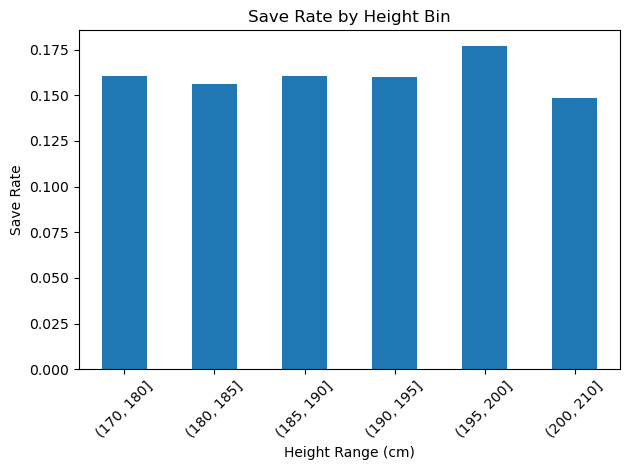

In [14]:
#Creating Frequency Distribution of Height and Save Rate
import matplotlib.pyplot as plt

goalie_df['height_bin'] = pd.cut(goalie_df['height'], bins=[170, 180, 185, 190, 195, 200, 210])
save_rates = goalie_df.groupby('height_bin')['save'].mean()
save_rates.plot(kind='bar', xlabel='Height Range (cm)', ylabel='Save Rate', title='Save Rate by Height Bin')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## FIFA Goalkeeper Ratings

In [15]:
#Standardizing overall FIFA ratings to prepare for joining data
attr_goalie = attr.sort_values('overall_rating', ascending=False).drop_duplicates('player_api_id')

In [16]:
#Merging FIFA ratings with Goalie df
goalie_fifa = pd.merge(
    goalie_df,
    attr_goalie[['player_api_id', 'overall_rating', 'potential', 
                 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 
                 'gk_reflexes']],
    on='player_api_id',
    how='left'
)
goalie_fifa.head(2)

,id,player_api_id,goalie_name,player_fifa_api_id,birthday,height,weight,matchday,OfficialMatchName,FinalResult,...,order,save,height_bin,overall_rating,potential,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,9,528212,aaron lennox,206592,1993-02-19 00:00:00,190.5,181,Third Round,Fraserburgh FC - Montrose FC,2:4,...,NaN,0.0,"(190, 195]",48.0,57.0,53.0,41.0,39.0,51.0,53.0
1,9,528212,aaron lennox,206592,1993-02-19 00:00:00,190.5,181,Third Round Replay,Montrose FC - Kelty Hearts FC,2:4 on pens,...,2.0,0.0,"(190, 195]",48.0,57.0,53.0,41.0,39.0,51.0,53.0


In [17]:
#Creating logistic regression to see which variables are significant

X = goalie_fifa[['overall_rating', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']]
X = sm.add_constant(X)
y = goalie_fifa['save']

logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.441520
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   save   No. Observations:                12321
Model:                          Logit   Df Residuals:                    12314
Method:                           MLE   Df Model:                            6
Date:                Mon, 14 Jul 2025   Pseudo R-squ.:                0.001772
Time:                        13:11:54   Log-Likelihood:                -5440.0
converged:                       True   LL-Null:                       -5449.6
Covariance Type:            nonrobust   LLR p-value:                  0.003669
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.5851      0.241    -10.715      0.000      -3.058      -2.112
overall_rating   

In [18]:
#Exploring non-linear random forest model performance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

X = goalie_fifa[['overall_rating', 'gk_diving', 'gk_handling', 'gk_kicking',
              'gk_positioning', 'gk_reflexes']].dropna()
y = goalie_fifa.loc[X.index, 'save']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91      2053
         1.0       0.36      0.01      0.02       412

    accuracy                           0.83      2465
   macro avg       0.60      0.50      0.46      2465
weighted avg       0.76      0.83      0.76      2465



In [19]:
#Improving model by oversampling minority class (SMOTE) and weighting model
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_resampled, y_resampled)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.66      0.74      2053
         1.0       0.20      0.42      0.27       412

    accuracy                           0.62      2465
   macro avg       0.52      0.54      0.50      2465
weighted avg       0.74      0.62      0.66      2465

